In [1]:
!pip install arrow

ac_monthly
[2038488.464946875, 2339728.558551698, 3050120.055427869, 3521519.362964162, 3712119.254083203, 4008824.468072939, 4241540.388522514, 3844615.828167166, 3267584.659285778, 2493305.324556913, 1467985.611935456, 1218243.035927681]
poa_monthly
[110.3815998318756, 131.1244664721939, 173.8348418511677, 205.6282478159669, 221.8068749420941, 243.061330679951, 260.1486891806244, 237.5333703680104, 195.3805808264201, 144.8267079441808, 82.8085144039231, 68.44423350034245]
solrad_monthly
[3.560696768770182, 4.68301665972121, 5.607575543586053, 6.854274927198896, 7.155060482003035, 8.102044355998366, 8.391893199374982, 7.662366786064852, 6.512686027547336, 4.671829288521962, 2.760283813464103, 2.207878500011047]
dc_monthly
[2139234.687218989, 2528310.178033782, 3237601.370672378, 3735604.82258364, 3892112.759795377, 4197791.439297097, 4437273.543335768, 4021324.825571341, 3420418.213696463, 2613448.428209016, 1545996.200886672, 1287040.516654707]


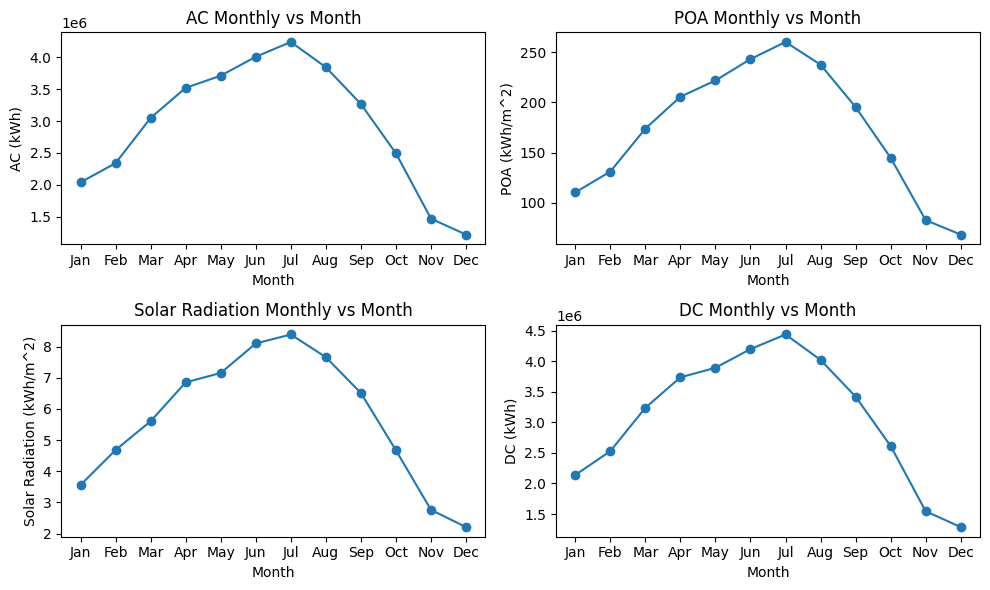

{'lat': 43.0099983215332, 'lon': -82.37999725341797, 'elev': 177.9199981689453, 'tz': -5.0, 'location': '1012181', 'city': '', 'state': 'Ontario', 'country': 'Canada', 'solar_resource_file': '1012181.csv', 'distance': 1771, 'weather_data_source': 'NSRDB PSM V3 GOES tmy-2020 3.2.0'}


In [2]:
import requests
import matplotlib.pyplot as plt


# Get the inputs from the GUI
surface_area = float(input("Enter your surface_area: "))
#address = address_entry.get()
address = str(input("Enter your postal code: "))

array_type = 2
module_type = 1
system_loss = 14.3
tilt = 20

# Calculate system capacity
solar_cell_efficiency = 21.3  # [%]
conversion_factor = 1  # [KW / m^2]
system_capacity = surface_area * solar_cell_efficiency * conversion_factor

# Define the URL for the PVWatts V8 API
url = "https://developer.nrel.gov/api/pvwatts/v8.json"
api_key = "rS4jhBrbjOjG2Rs1d2PZD6HGaIvO1gjDofyabEOV"

# Specify the parameters for the API request
params = {
    "api_key": api_key,
    "azimuth": 180,
    "system_capacity": system_capacity,
    "losses": system_loss,
    "array_type": array_type,
    "module_type": module_type,  
    "gcr": 0.4,
    "dc_ac_ratio": 1.2,
    "inv_eff": 96.0,
    "radius": 0,
    "timeframe": 'hourly',
    "dataset": "nsrdb",
    "tilt": tilt,
    "address": address,
    "albedo": 0.3,
    "bifaciality": 0.7
}

# Make the GET request to the PVWatts API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Display outputs
    ac_monthly = data["outputs"]["ac_monthly"]
    poa_monthly = data["outputs"]["poa_monthly"]
    solrad_monthly = data["outputs"]["solrad_monthly"]
    dc_monthly = data["outputs"]["dc_monthly"]
    
    station_info = data['station_info']
    
    print('ac_monthly')
    print(ac_monthly)
    
    print('poa_monthly')
    print(poa_monthly)
    
    print('solrad_monthly')
    print(solrad_monthly)
    
    print('dc_monthly')
    print(dc_monthly)
    

    # Plotting graphs
    months = [
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]

    plt.close('all')
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 2, 1)
    plt.plot(months, ac_monthly, marker='o')
    plt.title('AC Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('AC (kWh)')

    plt.subplot(2, 2, 2)
    plt.plot(months, poa_monthly, marker='o')
    plt.title('POA Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('POA (kWh/m^2)')

    plt.subplot(2, 2, 3)
    plt.plot(months, solrad_monthly, marker='o')
    plt.title('Solar Radiation Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('Solar Radiation (kWh/m^2)')

    plt.subplot(2, 2, 4)
    plt.plot(months, dc_monthly, marker='o')
    plt.title('DC Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('DC (kWh)')

    plt.tight_layout()
    plt.show()

else:
    print('err')



# get logatude and latitude from station
print(station_info)

latitude = station_info["lat"]
longitude = station_info["lon"]

## Stormio 10 day at a time data

In [3]:
import arrow
import requests

wind_height = input("Enter the height of the wind turbine: ")

windSpeeds = ['windSpeed', 'windSpeed20m', 'windSpeed30m', 'windSpeed40m', 'windSpeed50m', 'windSpeed80m', 'windSpeed100m']
otherParams = ['airTemperature', 'airTemperature100m', 'pressure', 'windDirection']

# Combine the lists
allParams = windSpeeds + otherParams

# Join all parameters into a single comma-separated string
params = ','.join(allParams)

# Define your latitude and longitude

# Set start to the first hour of January 1, 2023
start = arrow.get('2023-01-01T00:00:00Z')

# Set end to the last hour of December 31, 2023
end = arrow.get('2023-12-31T23:59:59Z')

# Initialize an empty list to store the collected data
collected_data = []

# Authorization header
headers = {
    'Authorization': '034fc6d0-da5a-11ee-94e4-0242ac130002-034fc7a2-da5a-11ee-94e4-0242ac130002'  # Replace YOUR_API_KEY_HERE with your actual API key
}

# Loop through the date range in 10-day increments
while start < end:
    # Calculate the end date for the current 10-day period, but do not exceed the overall end date
    current_end = start.shift(days=+9)
    if current_end > end:
        current_end = end

    response = requests.get(
        'https://api.stormglass.io/v2/weather/point',
        params={
            'lat': latitude,
            'lng': longitude,
            'params': params,
            'start': start.to('UTC').timestamp(),  # Convert to UTC timestamp
            'end': current_end.to('UTC').timestamp()  # Convert to UTC timestamp
        },
        headers=headers
    )

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response as JSON and append to collected_data
        json_data_new = response.json()
        collected_data.append(json_data_new)
    else:
        print(f"Error: {response.status_code}")

    # Move the start date to the next period
    start = current_end.shift(seconds=+1)

# At this point, collected_data contains all the data collected from the requests
# You can now process this data as needed


In [4]:
print(json_data_new)

{'hours': [{'airTemperature': {'noaa': 8.04, 'sg': 8.04}, 'airTemperature100m': {'noaa': 9.15, 'sg': 9.15}, 'pressure': {'noaa': 1015.93, 'sg': 1015.93}, 'time': '2023-12-27T00:00:00+00:00', 'windDirection': {'noaa': 146.09, 'sg': 146.09}, 'windSpeed': {'noaa': 2.29, 'sg': 2.29}, 'windSpeed100m': {'noaa': 1.93, 'sg': 1.93}, 'windSpeed20m': {'noaa': 1.39, 'sg': 1.39}, 'windSpeed30m': {'noaa': 1.52, 'sg': 1.52}, 'windSpeed40m': {'noaa': 1.62, 'sg': 1.62}, 'windSpeed50m': {'noaa': 1.71, 'sg': 1.71}, 'windSpeed80m': {'noaa': 1.87, 'sg': 1.87}}, {'airTemperature': {'noaa': 8.35, 'sg': 8.35}, 'airTemperature100m': {'noaa': 9.34, 'sg': 9.34}, 'pressure': {'noaa': 1015.62, 'sg': 1015.62}, 'time': '2023-12-27T01:00:00+00:00', 'windDirection': {'noaa': 136.09, 'sg': 136.09}, 'windSpeed': {'noaa': 2.38, 'sg': 2.38}, 'windSpeed100m': {'noaa': 2.69, 'sg': 2.69}, 'windSpeed20m': {'noaa': 1.79, 'sg': 1.79}, 'windSpeed30m': {'noaa': 1.98, 'sg': 1.98}, 'windSpeed40m': {'noaa': 2.13, 'sg': 2.13}, 'windS

In [5]:
!pip install --upgrade pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.6 MB 3.5 MB/s eta 0:00:04
   - -------------------------------------- 0.5/11.6 MB 5.6 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/11.6 MB 6.4 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/11.6 MB 7.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.6 MB 7.9 MB/s eta 0:00:02
   ------- -------------------------------- 2.3/11.6 MB 8.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.8/11.6 MB 9.0 MB/s eta 0:00:01
   ----------- ---------------------------- 3.2/11.6 MB 9.3 MB/s eta 0:00:01
   ------------ --------------------------- 3.7/11.6 MB 9.0 MB/s eta 0:00:01
   -------------- ------------------------- 4.2/11.6 MB 9.2 MB/s eta 0:00:01
   --------------- ------------------------ 4.6/11.6 MB 9.2 MB/s eta 0:00:01
   ----------------- ---------------------- 5.1/11.6 MB 9.3 MB/s eta 0:00:01
   ---

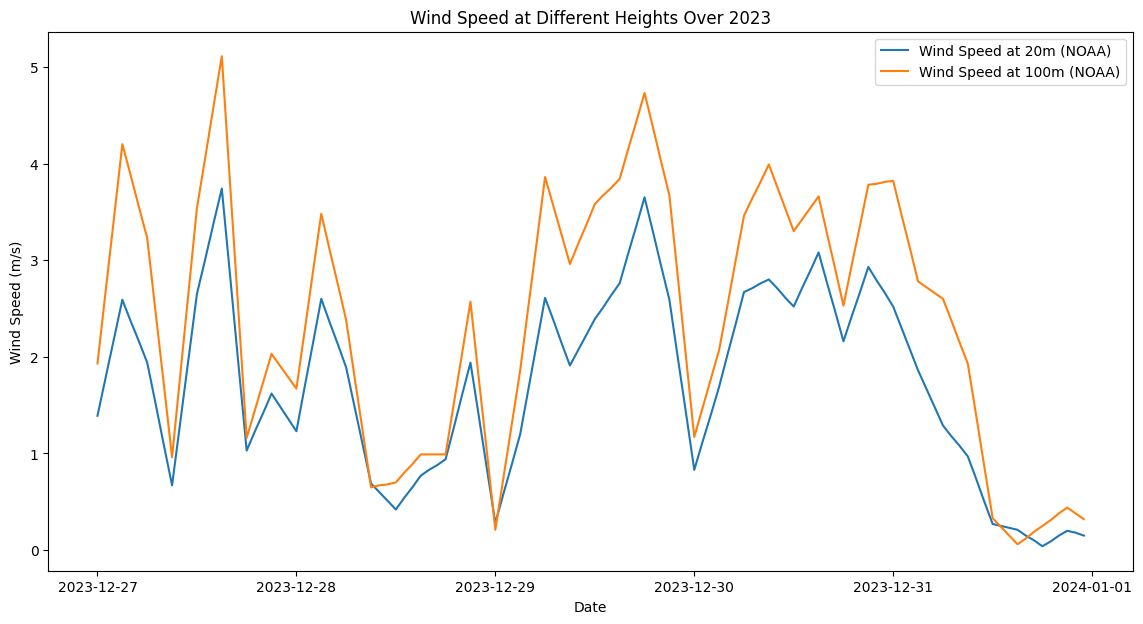

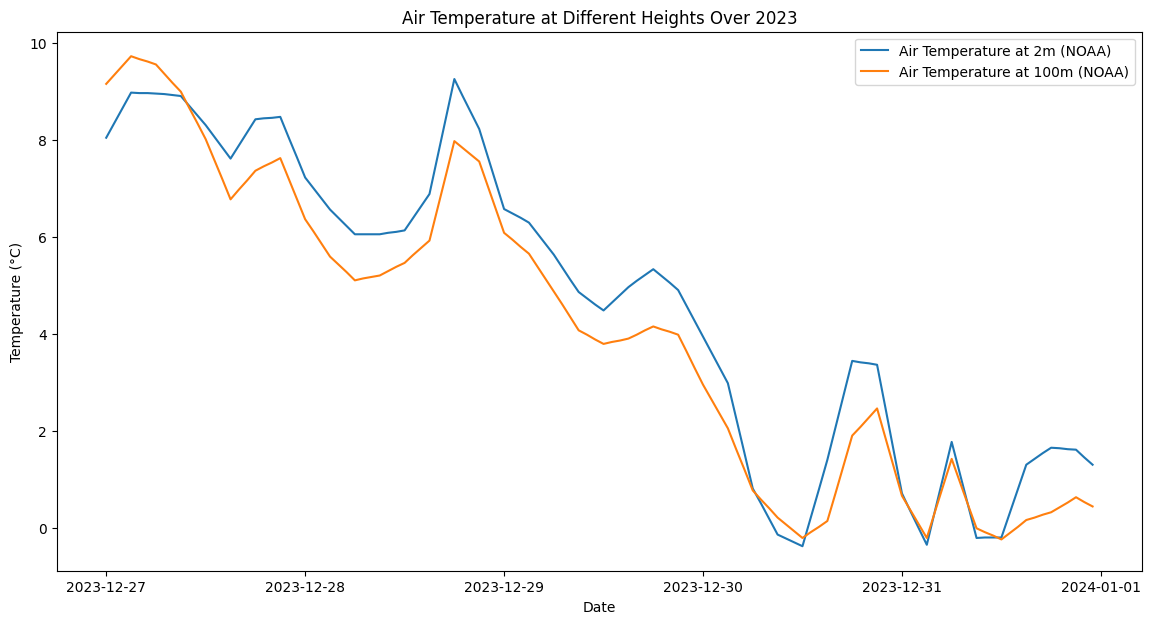

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Assuming 'json_data' is your loaded JSON response from the StormGlass API
# If it's in a file, you can load it with:
# with open('path_to_your_file.json') as f:
#     json_data = json.load(f)

# Convert JSON data to DataFrame
records = json_data_new['hours']
df = pd.DataFrame.from_records(records)

# Convert 'time' column to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Select columns for wind speed at different heights and temperature
wind_speed_20m = df['windSpeed20m'].apply(pd.Series)['noaa']
wind_speed_100m = df['windSpeed100m'].apply(pd.Series)['noaa']
air_temp = df['airTemperature'].apply(pd.Series)['noaa']
air_temp_100m = df['airTemperature100m'].apply(pd.Series)['noaa']

# Plot wind speed
plt.figure(figsize=(14, 7))
plt.plot(wind_speed_20m.index, wind_speed_20m, label='Wind Speed at 20m (NOAA)')
plt.plot(wind_speed_100m.index, wind_speed_100m, label='Wind Speed at 100m (NOAA)')
plt.title('Wind Speed at Different Heights Over 2023')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()

# Plot temperature
plt.figure(figsize=(14, 7))
plt.plot(air_temp.index, air_temp, label='Air Temperature at 2m (NOAA)')
plt.plot(air_temp_100m.index, air_temp_100m, label='Air Temperature at 100m (NOAA)')
plt.title('Air Temperature at Different Heights Over 2023')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


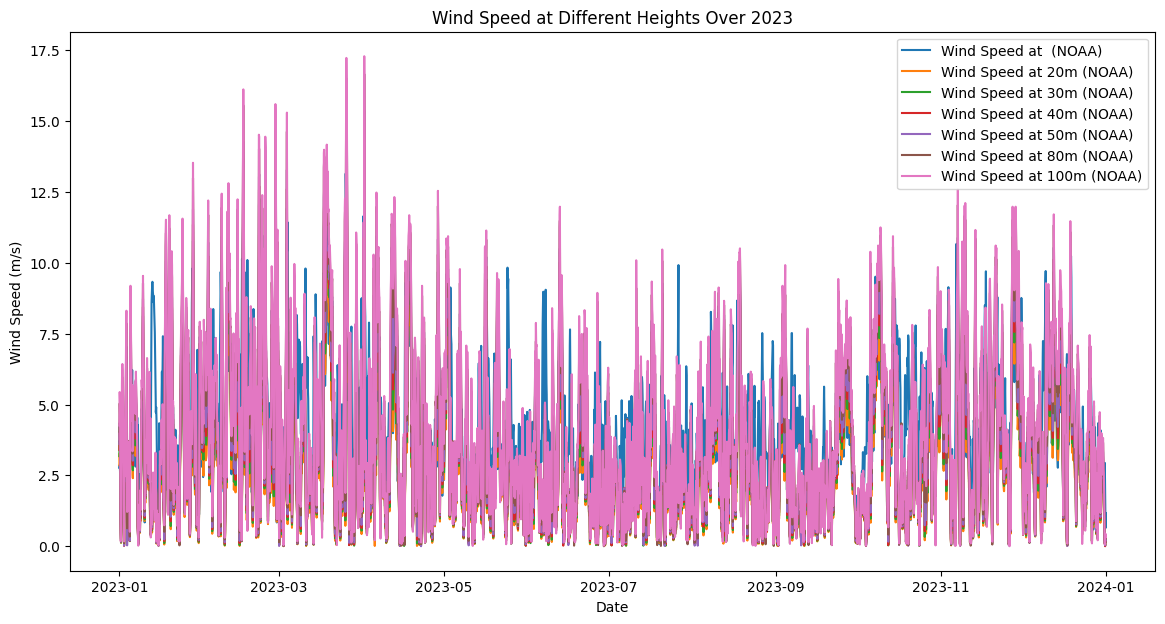

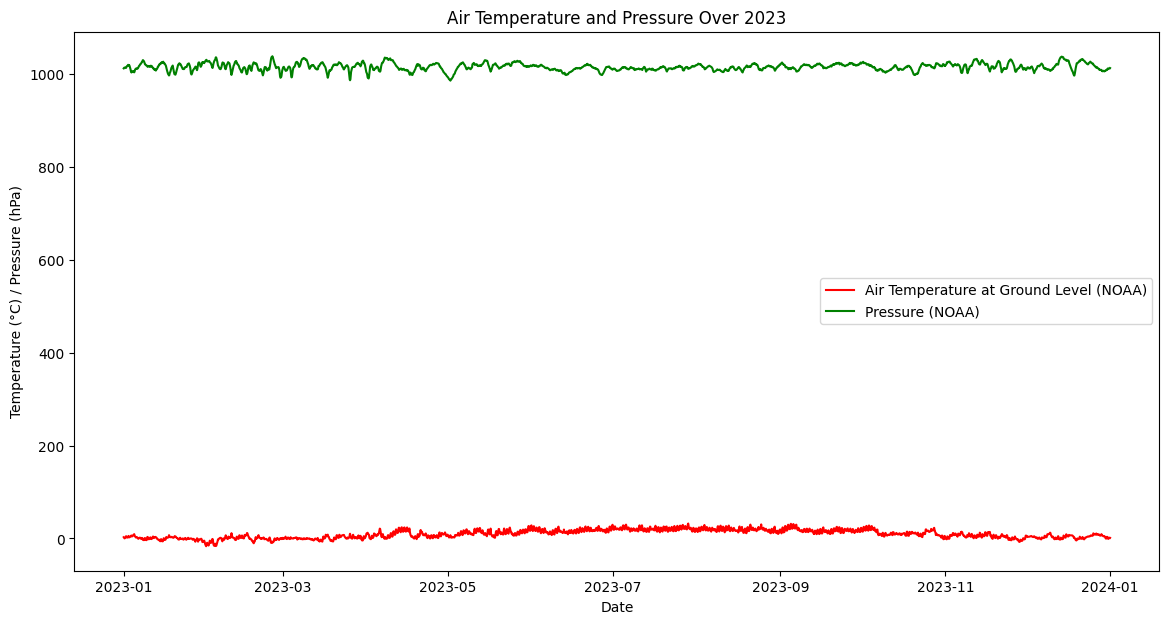

KeyError: 'noaa'

<Figure size 1400x700 with 0 Axes>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate all hourly data from collected_data
all_hours = []
for data in collected_data:
    all_hours.extend(data['hours'])

# Convert aggregated data to DataFrame
df = pd.DataFrame.from_records(all_hours)

# Convert 'time' column to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Extracting and plotting data for wind speed at different heights
plt.figure(figsize=(14, 7))

# Wind speeds
wind_speed_heights = ['windSpeed', 'windSpeed20m', 'windSpeed30m', 'windSpeed40m', 'windSpeed50m', 'windSpeed80m', 'windSpeed100m']
#wind_speed_heights = ['windSpeed','windSpeed100m']

for height in wind_speed_heights:
    df[height] = df[height].apply(pd.Series)['noaa']
    plt.plot(df.index, df[height], label=f'Wind Speed at {height.replace("windSpeed", "")} (NOAA)')

plt.title('Wind Speed at Different Heights Over 2023')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()

# Temperature and pressure
plt.figure(figsize=(14, 7))

# Air temperature at ground level
df['airTemperature'] = df['airTemperature'].apply(pd.Series)['noaa']
plt.plot(df.index, df['airTemperature'], label='Air Temperature at Ground Level (NOAA)', color='red')

# Assuming pressure data is structured similarly
df['pressure'] = df['pressure'].apply(pd.Series)['noaa']
plt.plot(df.index, df['pressure'], label='Pressure (NOAA)', color='green')

plt.title('Air Temperature and Pressure Over 2023')
plt.xlabel('Date')
plt.ylabel('Temperature (°C) / Pressure (hPa)')
plt.legend(loc='right')
plt.show()



plt.show()

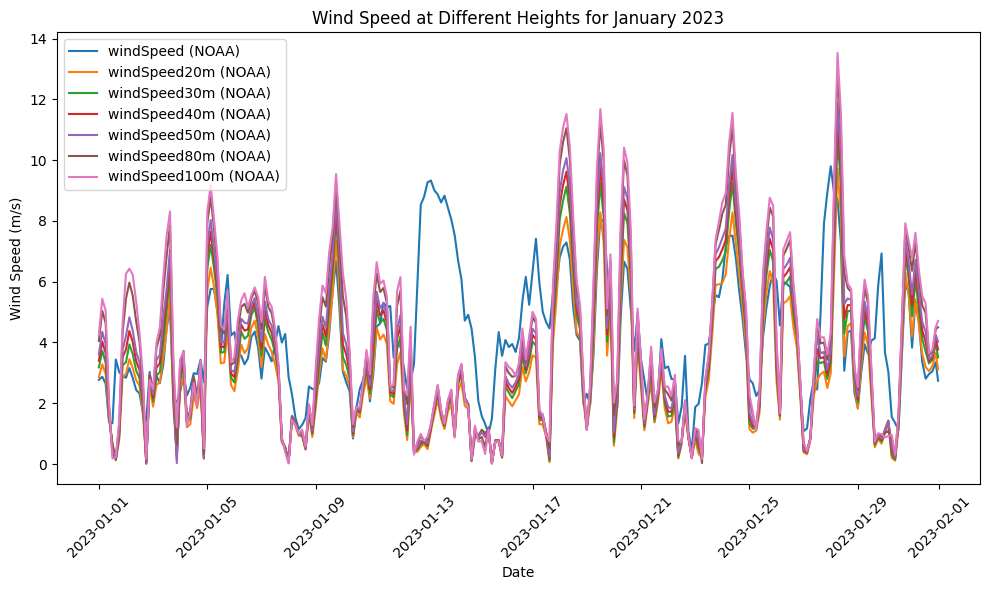

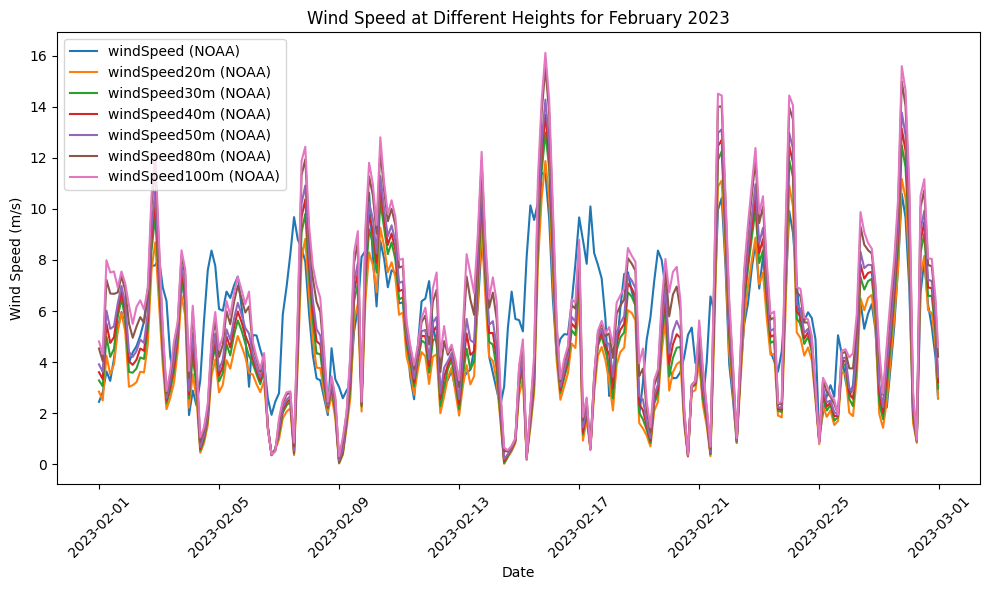

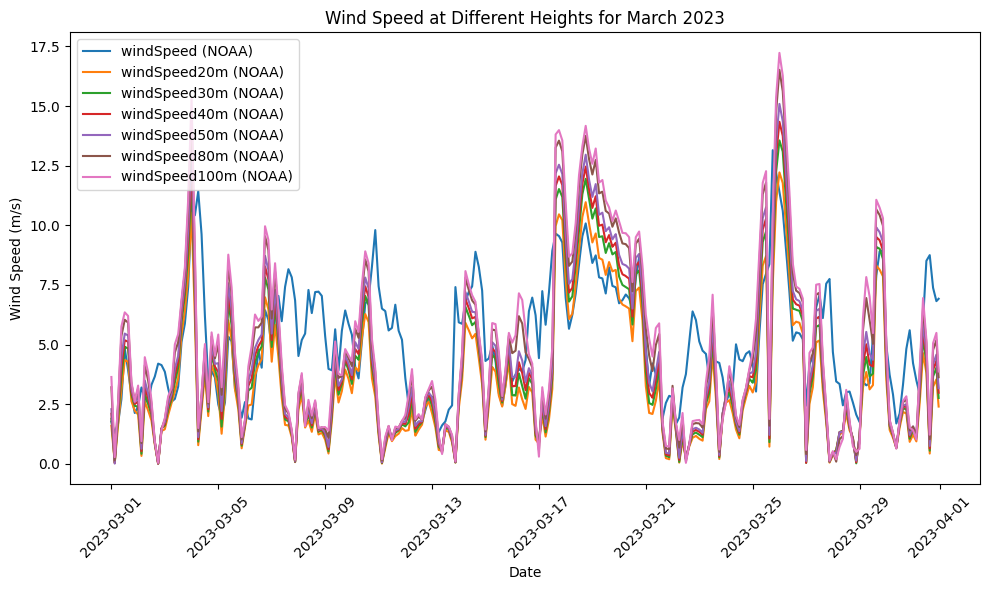

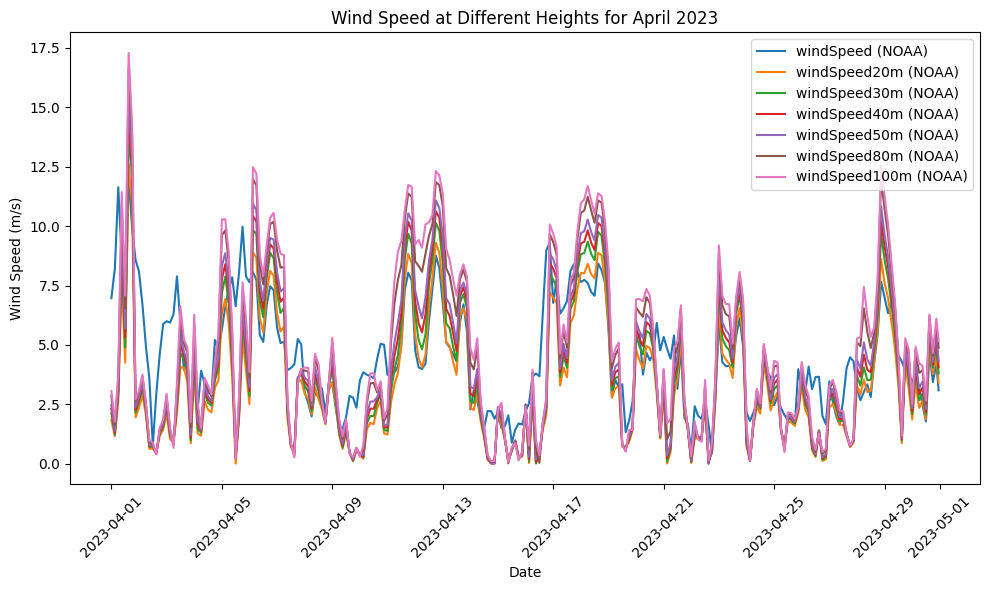

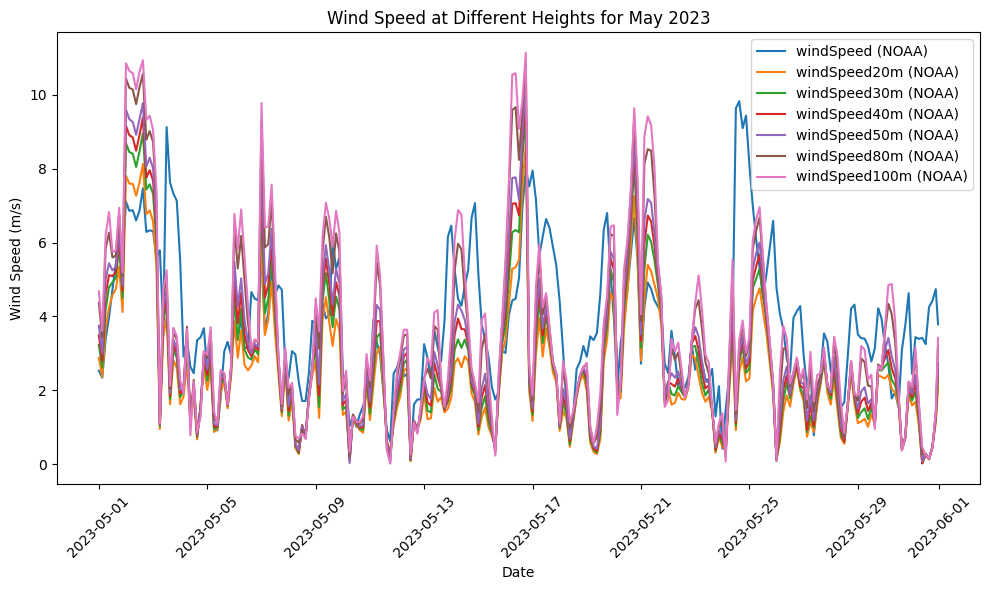

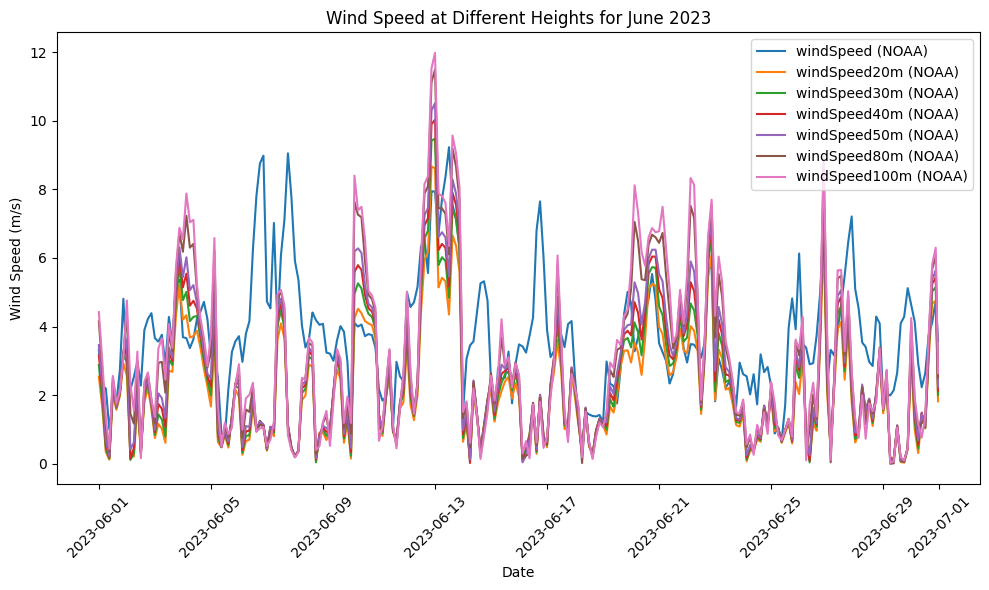

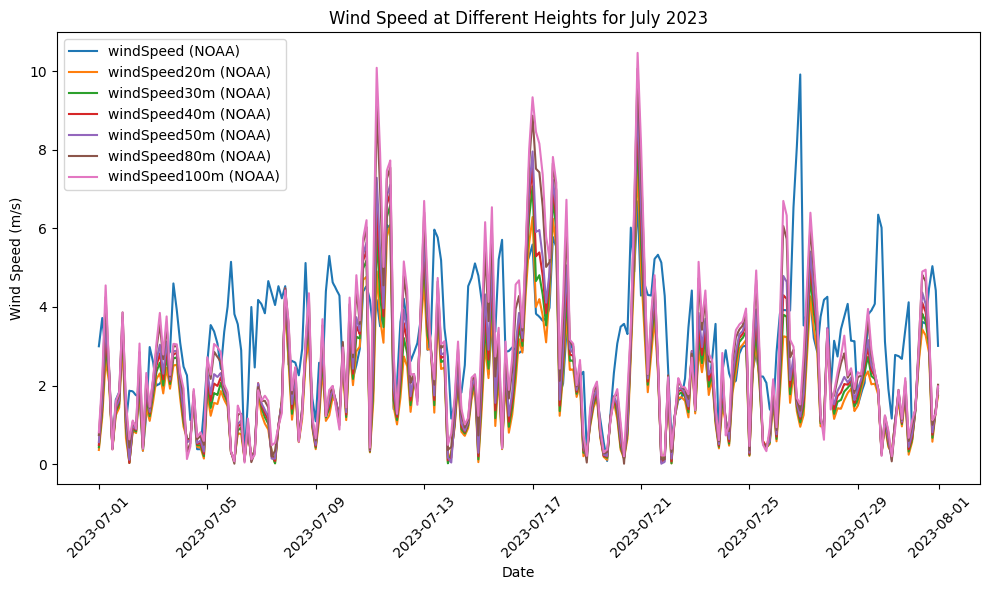

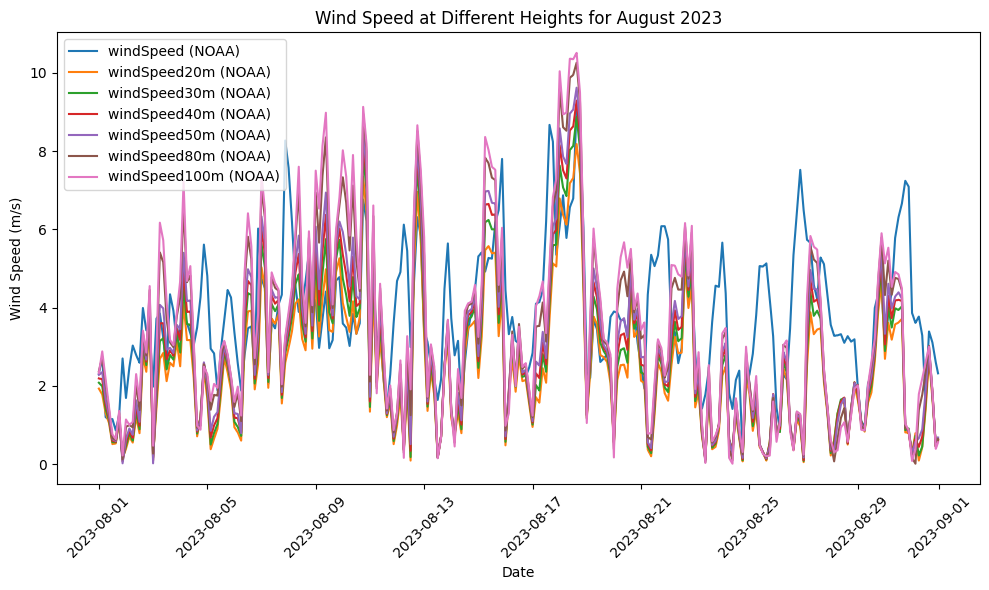

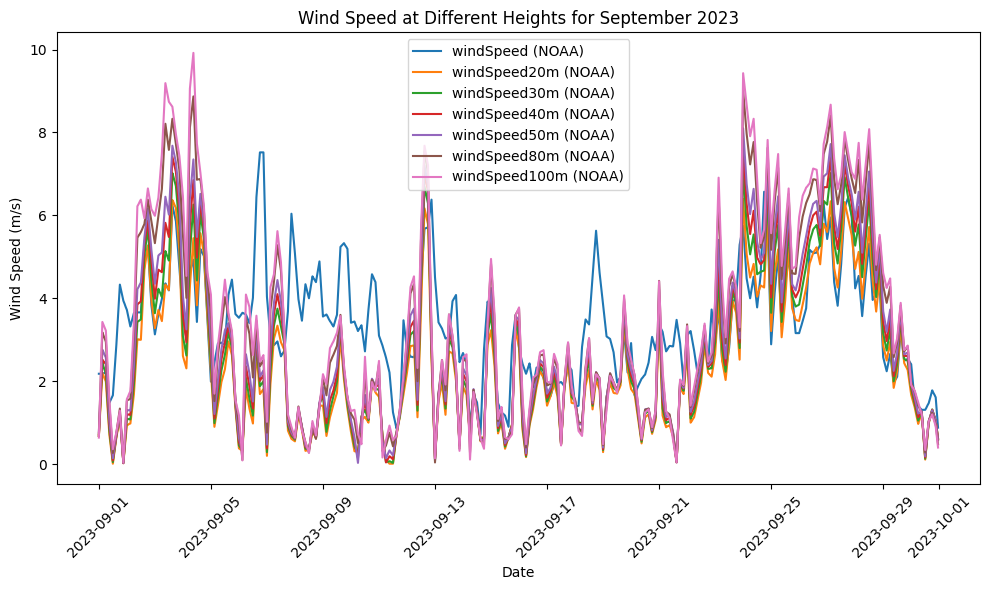

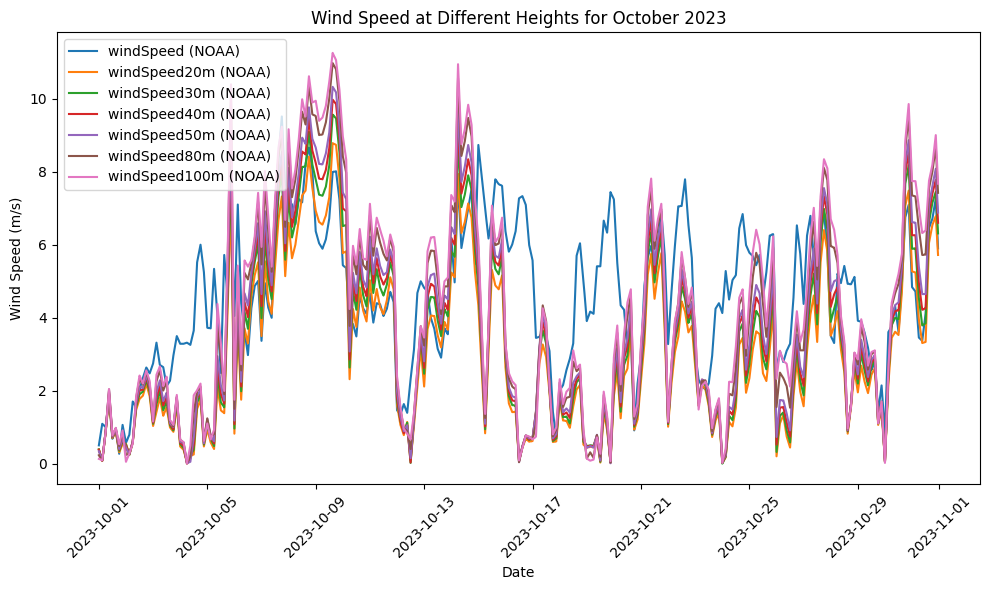

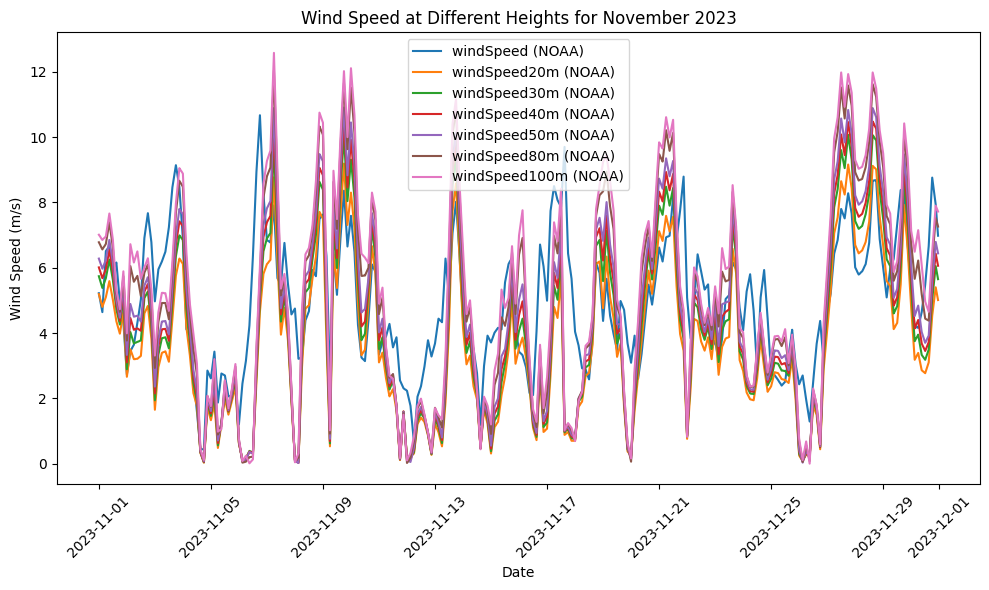

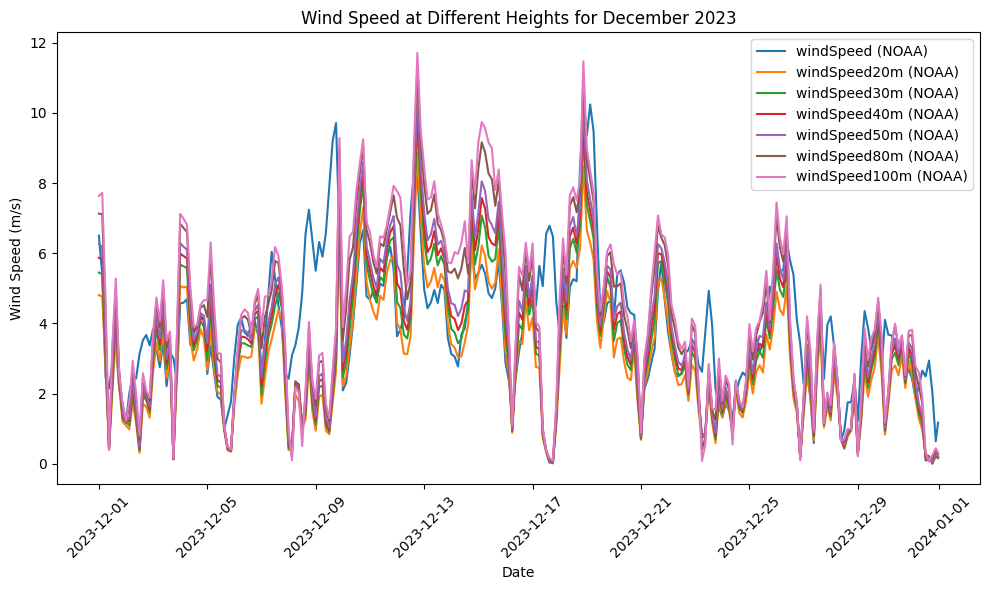

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate all hourly data from collected_data
all_hours = []
for data in collected_data:
    all_hours.extend(data['hours'])

# Convert aggregated data to DataFrame
df = pd.DataFrame.from_records(all_hours)

# Convert 'time' column to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Convert wind speed columns to numeric values and handle missing data
wind_speed_heights = ['windSpeed', 'windSpeed20m', 'windSpeed30m', 'windSpeed40m', 'windSpeed50m', 'windSpeed80m', 'windSpeed100m']
for height in wind_speed_heights:
    df[height] = pd.to_numeric(df[height].apply(pd.Series)['noaa'], errors='coerce')

# Loop through each month
for month in range(1, 13):
    # Filter the DataFrame for the current month
    monthly_df = df[df.index.month == month]

    # Check if there is data for the month
    if not monthly_df.empty:
        plt.figure(figsize=(10, 6))

        for height in wind_speed_heights:
            plt.plot(monthly_df.index, monthly_df[height], label=f'{height} (NOAA)')

        plt.title(f'Wind Speed at Different Heights for {monthly_df.index[0].strftime("%B")} 2023')
        plt.xlabel('Date')
        plt.ylabel('Wind Speed (m/s)')
        plt.legend()
        plt.xticks(rotation=45)  # Rotate date labels for better readability
        plt.tight_layout()  # Adjust layout to make room for the rotated date labels
        plt.show()
    else:
        print(f"No data for month {month}")


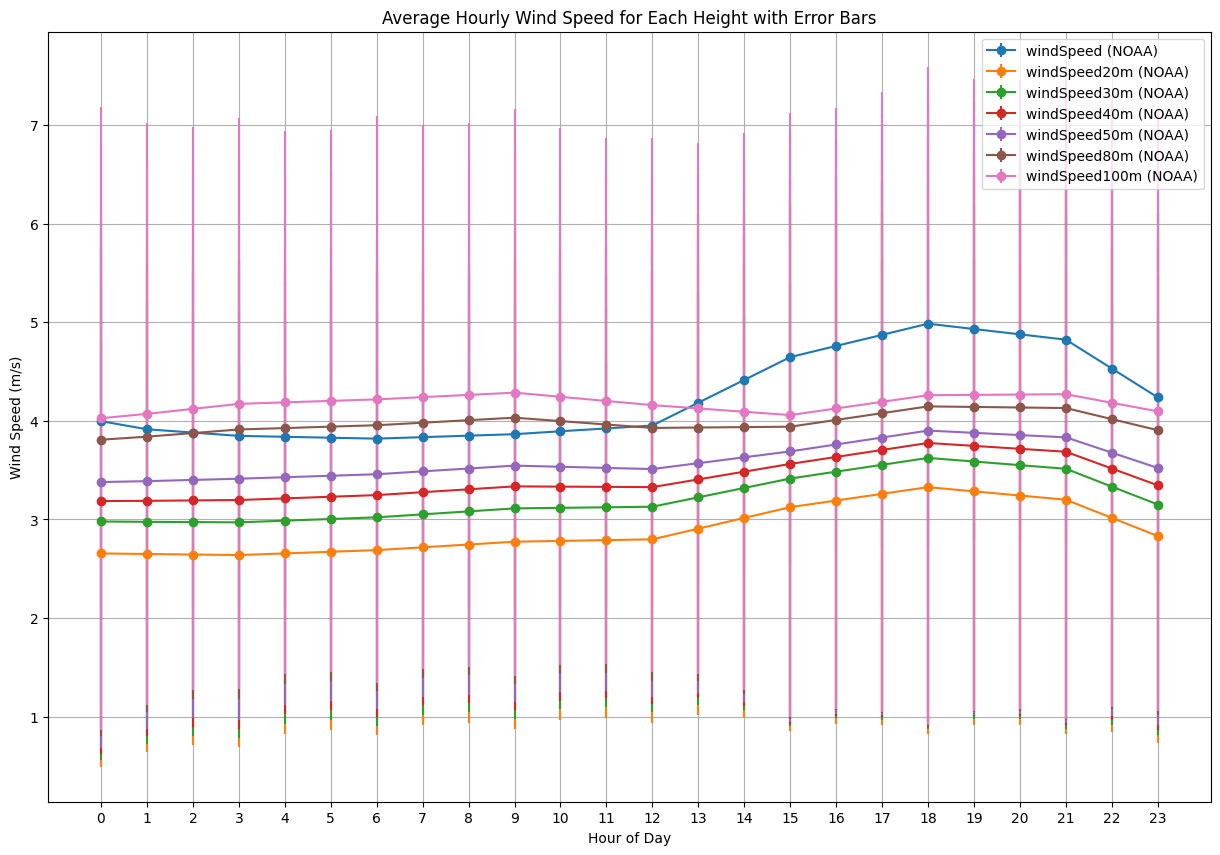

In [10]:
import numpy as np

# First, add an 'hour' column to the DataFrame for grouping
df['hour'] = df.index.hour

# Initialize a dictionary to hold our summary stats for each height
hourly_stats = {height: {'mean': [], 'std': []} for height in wind_speed_heights}

# Calculate mean and std for each height and hour
for height in wind_speed_heights:
    for hour in range(24):
        # Filter data for the current hour and height
        hourly_data = df[df['hour'] == hour][height]
        # Calculate mean and std, append to the respective lists
        hourly_stats[height]['mean'].append(hourly_data.mean())
        hourly_stats[height]['std'].append(hourly_data.std())

# Plotting
plt.figure(figsize=(15, 10))

# Plot mean wind speed with error bars for each height
for height in wind_speed_heights:
    plt.errorbar(range(24), hourly_stats[height]['mean'], yerr=hourly_stats[height]['std'], label=f'{height} (NOAA)', fmt='-o')

plt.title('Average Hourly Wind Speed for Each Height with Error Bars')
plt.xlabel('Hour of Day')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()


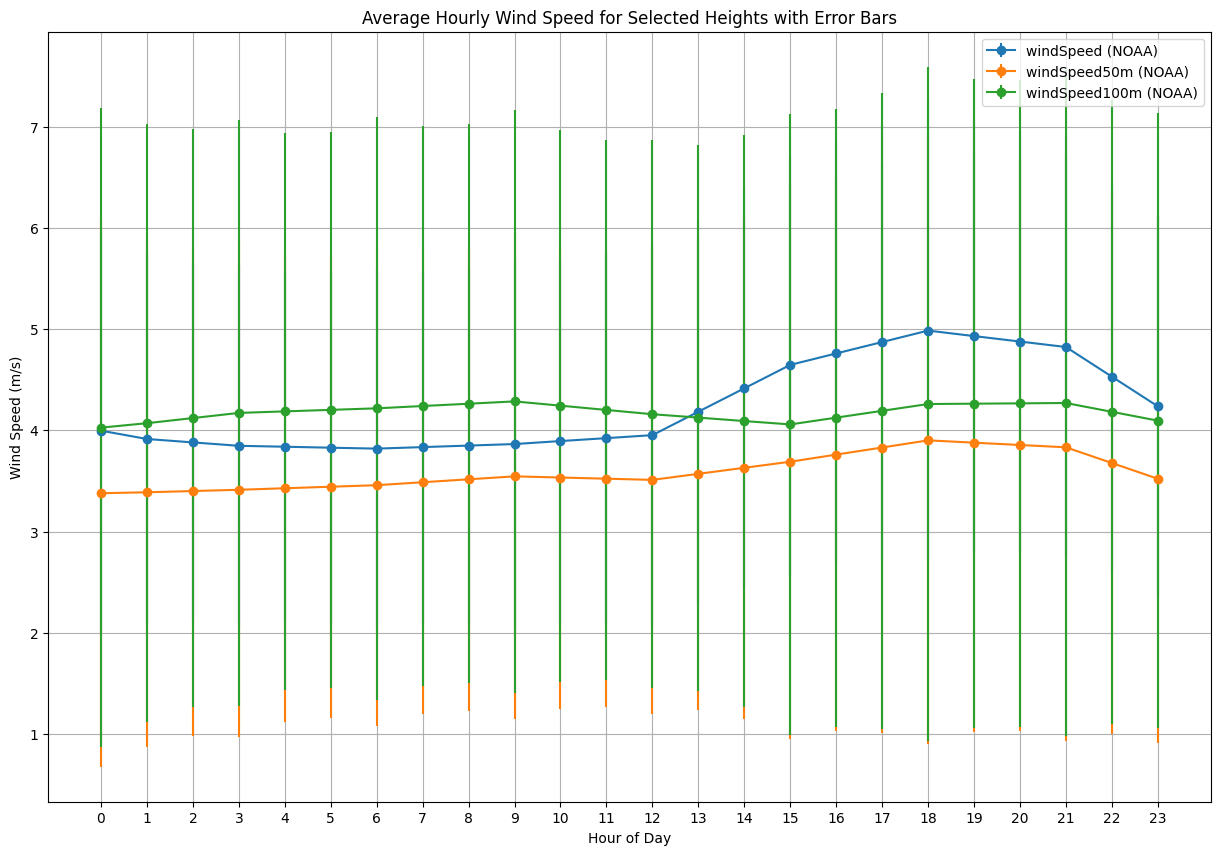

In [11]:
# Reduced set of wind speed heights for simplicity in visualization
selected_wind_speed_heights = ['windSpeed', 'windSpeed50m', 'windSpeed100m']

# Initialize a dictionary to hold our summary stats for the selected heights
hourly_stats_selected = {height: {'mean': [], 'std': []} for height in selected_wind_speed_heights}

# Calculate mean and std for the selected heights and each hour
for height in selected_wind_speed_heights:
    for hour in range(24):
        # Filter data for the current hour and height
        hourly_data = df[df['hour'] == hour][height]
        # Calculate mean and std, append to the respective lists
        hourly_stats_selected[height]['mean'].append(hourly_data.mean())
        hourly_stats_selected[height]['std'].append(hourly_data.std())

# Plotting for the selected wind speed heights
plt.figure(figsize=(15, 10))

# Plot mean wind speed with error bars for each selected height
for height in selected_wind_speed_heights:
    plt.errorbar(range(24), hourly_stats_selected[height]['mean'], yerr=hourly_stats_selected[height]['std'], label=f'{height} (NOAA)', fmt='-o')

plt.title('Average Hourly Wind Speed for Selected Heights with Error Bars')
plt.xlabel('Hour of Day')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()


C:\Users\npace\AppData\Local\Temp\ipykernel_27440\552766483.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_wind_speeds = daily_data[height].resample('H').mean()  # Resample to hourly mean


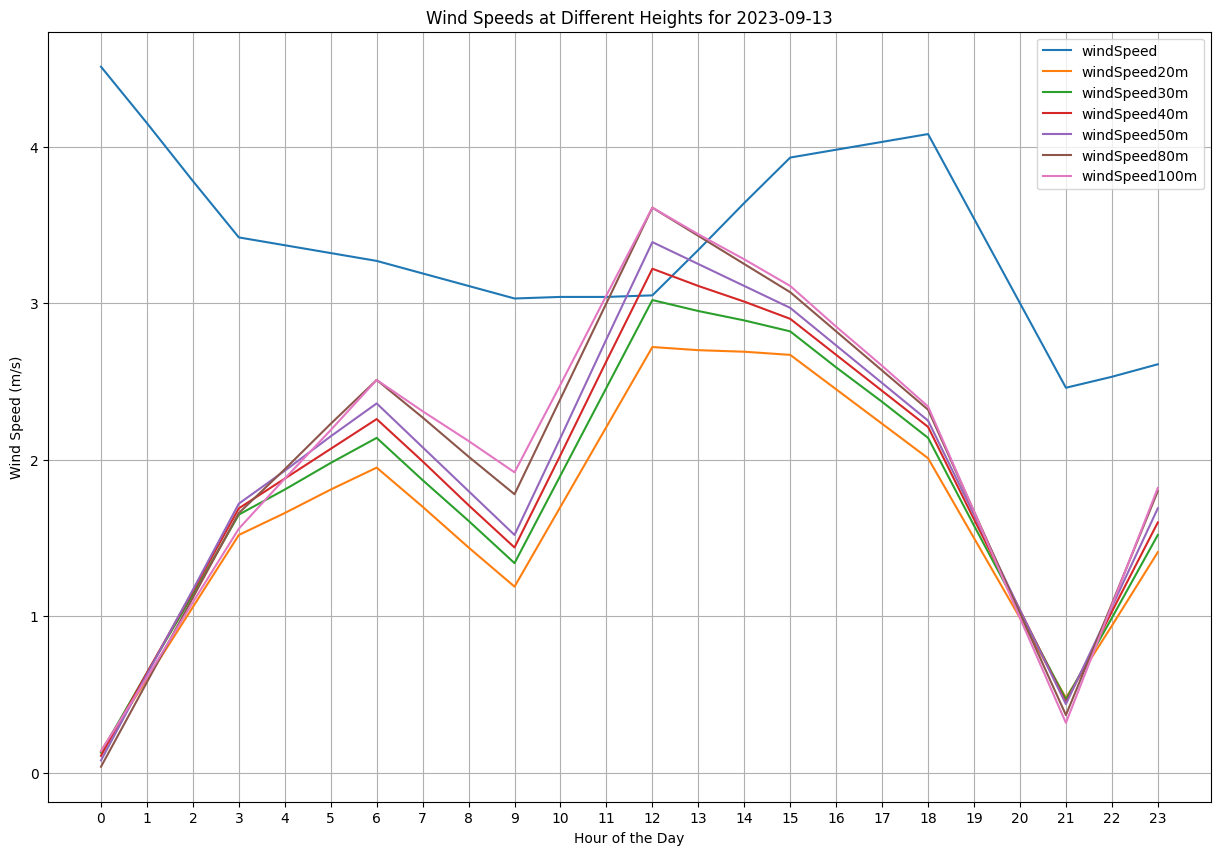

In [12]:
import matplotlib.pyplot as plt

# User inputs a specific day (format: YYYY-MM-DD)
user_input_date = input("Enter a specific day (YYYY-MM-DD): ")

try:
    specific_day = pd.to_datetime(user_input_date)
    # Filter the DataFrame for the specific day
    daily_data = df.loc[df.index.date == specific_day.date()]

    if daily_data.empty:
        print("No data available for this day.")
    else:
        plt.figure(figsize=(15, 10))

        # Plot wind speed for each height
        for height in wind_speed_heights:  # Assuming wind_speed_heights is defined as before
            hourly_wind_speeds = daily_data[height].resample('H').mean()  # Resample to hourly mean
            plt.plot(hourly_wind_speeds.index.hour, hourly_wind_speeds, label=height)

        plt.title(f"Wind Speeds at Different Heights for {specific_day.strftime('%Y-%m-%d')}")
        plt.xlabel('Hour of the Day')
        plt.ylabel('Wind Speed (m/s)')
        plt.legend()
        plt.xticks(range(24))
        plt.grid(True)
        plt.show()

except ValueError as e:
    print("Invalid date format. Please enter the date in YYYY-MM-DD format.")


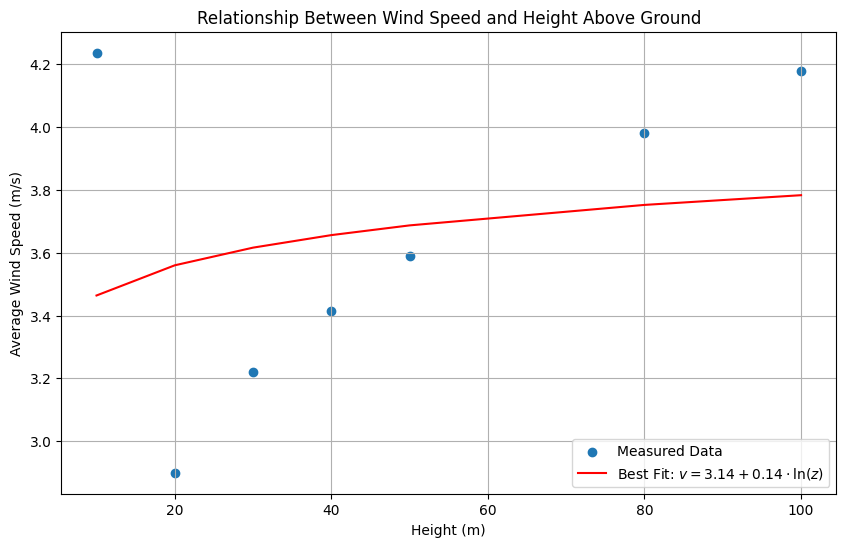

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming 'collected_data' is a list of dictionaries with the aggregated data

# Initialize lists to store average wind speed and corresponding heights
average_wind_speeds = []
heights = [10, 20, 30, 40, 50, 80, 100]  # Heights in meters

# Calculate the average wind speed for each height
for height in heights:
    wind_speed_key = f'windSpeed{height}m' if height > 10 else 'windSpeed'
    wind_speeds = []

    for data_point in collected_data:
        for hour_data in data_point['hours']:
            if wind_speed_key in hour_data:
                wind_speeds.append(hour_data[wind_speed_key]['noaa'])

    average_wind_speeds.append(np.mean(wind_speeds))

# Define a function to fit, e.g., a logarithmic wind profile (common in wind engineering)
def log_wind_profile(z, a, b):
    return a + b * np.log(z)

# Fit the curve
heights_real = heights # Heights in meters

popt, pcov = curve_fit(log_wind_profile, heights_real[1:], average_wind_speeds[1:])  # Exclude the 0m height for log fitting

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(heights_real, average_wind_speeds, label='Measured Data')
plt.plot(heights_real, log_wind_profile(np.array(heights_real, dtype=float), *popt), 'r-', label=f'Best Fit: $v = {popt[0]:.2f} + {popt[1]:.2f} \cdot \ln(z)$')

plt.title('Relationship Between Wind Speed and Height Above Ground')
plt.xlabel('Height (m)')
plt.ylabel('Average Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()
